In [24]:
from utils import plot_states, get_weather_example, HMM
import numpy as np

# Learning HMMs from Observation Sequences

In **Problem 1**, we explored HMM inference algorithms in detail. To test these algorithms, we worked with fully defined HMMs, where the parameters — $\mathbf{A}$ (transition probabilities), $\mathbf{B}$ (observation probabilities) and $\mathbf{\Pi}$ (initial state probabilities) — were known.

However, in real-world scenarios, we often lack direct access to these parameters. Instead, we only observe sequences of outputs, leaving the hidden system dynamics and observation dependencies to be inferred. In this notebook, we will explore the **Baum-Welch Algorithm** for learning HMM parameters from example observation sequences. 

To get the most out of this exercise, review the lecture slides on *Learning* (SD 6a, p. 54-68) carefully before proceeding.

## Likelihood forward and backward messages

<div class="alert alert-warning">
    Implement the algorithms to compute the <i>likelihood forward messages</i> and the <i>backward messages</i>. (1 point)
</div>

To compute the expected values of the hidden counts (SD 6a, p. 62), we need the **likelihood forward message** and the **backward messages**.

- The likelihood forward message is calculated as: $$P(S^{(t+1)}, \mathbf{o}^{(1:t+1)}) = \mathsf{lf}^{(1:t+1)} = \mathbf{B}[o^{(t+1)}] \circ \mathbf{A}^T \mathsf{lf}^{(1:t)}$$
$\mathsf{lf}^{(1:t)}_i$: the likelihood of observing $\mathbf{o}^{(1:t)}$ and ending up in state $s^{t}_i$
- The backward message is given by:
$$ P(\mathbf{o}^{(t+1:T)} \mid S^{(t)}) = \mathsf{b}^{(t+1:T)} = \mathbf{A}(\mathbf{B}[o^{(t+1)}]^T \circ \mathsf{b}^{(t+2:T)})$$
$\mathsf{b}^{(t+1:T)}_i$: the probability of observing $\mathbf{o}^{(t+1:T)}$, given that we are in $s^{t}_i$

*Hints*:
- Reuse your implementations of the *forward* and *backward* functions of Problem 1.
- Remove normalization (the $\frac{1}{Z}$ constant) from both *forward* and *backward* functions.
- Initialize $\mathsf{b}^{(T+1:T)}$ as a vector of ones instead of a vector of $\frac{\mathbf{1}}{\mid S \mid}$.

*Note*:
- While the Baum-Welch Algorithm often uses normalized forward and backward messages for numerical stability, this exercise focuses on the simplest implementation. For this reason, normalization is omitted here.

In [25]:
def likelihood_forward(hmm: HMM, observations: np.ndarray):
    """
    Computes the likelihood forward message for a given 
    Hidden Markov Model and observations.
    
    :param hmm: HMM datastructure
    :param observations: Numpy array containing the observations

    :return: likelihood forward message (each row represents a time step)
    """
    
    # initialize empty array for the forward messages
    f = np.empty((len(observations) + 1, hmm.num_states))
    
    # YOUR CODE HERE
    # raise NotImplementedError()

    f[0] = hmm.pi
    for t in range(1, len(observations) + 1):
        obs_t = observations[t - 1]  
        f[t] = hmm.B[obs_t] * (hmm.A.T @ f[t - 1])
         
    return f

In [26]:
# sanity check using weather example from the lecture slides
expected_f = np.array([
 [0.2, 0.3, 0.5],
 [0.076, 0.087, 0.104],
 [0.0291, 0.03416, 0.02468],
 [0.002094, 0.0095082, 0.0211836]
])


actual_f = likelihood_forward(*get_weather_example())

# check shape
assert actual_f.shape == expected_f.shape, f'Shape mismatch, expected {expected_f.shape}, but got {actual_f.shape}.'

# check values
assert np.allclose(expected_f, actual_f), f'Result mismatch, expected \n{expected_f} \nbut got \n{actual_f}. Double-check that you have removed the normalization.'


In [27]:
def backward(hmm: HMM, observations: np.ndarray):
    """
    Computes the backward message (unnormalized) for a given 
    Hidden Markov Model and observations.
    
    :param hmm: HMM datastructure
    :param observations: Numpy array containing the observations

    :return: backward message (each row represents a time step)
    """
    # initialize empty array for the backward messages
    b = np.empty((len(observations) + 1, hmm.num_states))
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    b[len(observations)] = np.ones(hmm.num_states) 

    for t in reversed(range(len(observations))):
        obs_t = observations[t]
        b[t] = hmm.A @ (hmm.B[obs_t] * b[t + 1])

    return b

In [28]:
# sanity check using the weather example

expected_f = np.array([
    [0.03932, 0.038136, 0.026962],
    [0.1316, 0.1286, 0.1115],
    [0.31, 0.32, 0.52],
    [1.0, 1.0, 1.0]
])

actual_f = backward(*get_weather_example())

# check shape
assert actual_f.shape == expected_f.shape,f'Shape mismatch, expected {expected_f.shape}, but got {actual_f.shape}.'
# check values
assert np.allclose(expected_f, actual_f), f'Result mismatch, expected \n{expected_f} \nbut got \n{actual_f}. Double-check that you have removed the normalization.'

## Sample observations from an HMM

<div class="alert alert-warning">
    Implement the <i>sample_hmm</i> function, which samples observations from an HMM. (2 points)
</div>

We will use this function to sample observations from a known HMM. We will then use the observations to re-discover the original HMM that has generated our observations.

`sample_hmm` takes two parameters:
- `hmm`: An instance of the HMM class.
- `sequence_length`: The length of the observation sequence to sample.

`sample_hmm` must return one object:
- a NumPy array of shape `(sequence_length,)` containing a sequence of observations.

*Hints*:
- Sample states and observations in the following order: $s^{(0)}$, $s^{(1)}$, $o^{(1)}$, $s^{(2)}$, $o^{(2)}$, $s^{(3)}$, ...
- Sample the inital state $s^{(0)}$ from `hmm.pi`.
- Select the correct row of `hmm.A` based on the current state to sample the next state.
- Select the correct column of `hmm.B` based on the current state to sample the observation.
- Recall that observations start at $t=1$. There is no observation at $t=0$, so `observations[0]` corresponds to $t=1$.
- Use the `sample_categorical()` function to sample from a discrete 1-D probability distribution. 

In [29]:
from utils import sample_categorical
help(sample_categorical)

Help on function sample_categorical in module utils:

sample_categorical(dist: numpy.ndarray) -> numpy.int64
    Draws a single sample from a categorical distribution.
    :param dist: NumPy array listing the probability of each outcome.
    :returns: Index of the sampled element.



In [30]:
def sample_hmm(hmm: HMM, sequence_length: int):
    """
    Sample a sequence of observations from a given HMM.

    :param hmm: An instance of the HMM class.
    :param sequence_length: Length of the observation sequence to generate.
    :return: array of sampled observations (length = sequence_length).
    """

    assert sequence_length >= 1
    
    # Initialize the state and observation sequences
    states = np.zeros(sequence_length + 1, dtype=np.int64)
    observations = np.zeros(sequence_length, dtype=np.int64)

    # YOUR CODE HERE
    # raise NotImplementedError()

    states[0] = sample_categorical(hmm.pi)
    
    for t in range(1, sequence_length + 1):
        states[t] = sample_categorical(hmm.A[states[t - 1]])
        observations[t - 1] = sample_categorical(hmm.B[:, states[t]])
    
    return observations

In [31]:
# sanity checks
weather_hmm = get_weather_example()[0]
np.random.seed(42)
expected = np.array([1, 0, 0, 1, 0, 2, 0, 1, 1, 1])
actual = sample_hmm(weather_hmm, 10)

assert type(actual) == np.ndarray, f'\nWrong output type!\nExpected: np.ndarray\nGiven:\t  {type(actual)}'
assert actual.shape == (10, ), f'\nWrong output shape!\nExpected: (10, )\nGiven:\t  {actual.shape}'
assert actual.dtype == np.int64, f'\nWrong numpy array data type!\nExpected: np.int64\nGiven:\t  {actual.dtype}'
assert np.all(np.isclose(actual, expected)), f'Result mismatch, expected \n{expected} \nbut got \n{actual}.'


## Computing the Likelihood of an HMM

<div class="alert alert-warning">
    Implement the <i>hmm_log_likelihood</i> function, which computes the log-likelihood of observations under a given HMM. (2 points)
</div>

We will use this function to assess how well a given HMM fits the observations.

`hmm_log_likelihood` takes two parameters:
- `hmm`: An instance of the HMM class.
- `observations_list`: A list of NumPy arrays, where:
  - `len(observations_list) = n_samples` (number of observation sequences).
  - Each array is of shape `(sequence_length,)`.

`hmm_log_likelihood` must return one number:
- A single number representing the sum of the log-likelihoods of all observation sequences under the HMM.

*Hints*:
- Have a look at the lecture slides (SD 6a, p. 48-53).
- Use the `likelihood_forward` function to compute the likelihood for each observation sequence.
- For a single sequence, compute: $P(\mathbf{o}^{(1:T)}) = \sum_i \mathsf{lf}_i^{(1:T)}$
  where $\mathsf{lf}_i^{(1:T)}$ is the final likelihood forward message.
- Accumulate the log probabilities over all observation sequences by summing the individual $\log P(\mathbf{o}^{(1:T)})$

In [32]:
def hmm_log_likelihood(hmm: HMM, observations_list: list):
    """
    Computes the log-likelihood of the observations
    under the given HMM.
    
    :param hmm: An instance of the HMM class.
    :param observations_list: List of Numpy arrays, each representing an
                              observation sequence of shape (sequence_length,).

    :return: Log-likelihood of the observation sequences under the HMM.
    """
    sum_log_prob = 0
    
    # YOUR CODE HERE
    # raise NotImplementedError()

    for obs in observations_list:
        lf = likelihood_forward(hmm, obs)
        likelihood_obs = np.sum(lf[len(obs)])
        log_likelihood_obs = np.log(likelihood_obs)
        sum_log_prob += log_likelihood_obs
    
    return sum_log_prob

In [33]:
# sanity checks
weather_hmm = get_weather_example()[0]
np.random.seed(42)
samples = [
    np.array([1, 0, 0, 1, 0, 2, 0, 1, 1, 1]),
    np.array([1, 0, 2, 1, 0, 2, 0, 0, 0, 1]),
    np.array([1, 0, 1, 1, 1, 1, 2, 2, 2, 1]),
]

actual = hmm_log_likelihood(weather_hmm, samples)
expected = -32.8822
assert np.all(np.isclose(expected, actual)), f"Computed log-likelihood value ({round(actual, 3)}) differs from expected ({round(expected, 3)})."


## Implement the Baum-Welch algorithm

<div class="alert alert-warning">
    Implement the <i>baum_welch</i> function, which learns the parameters of an HMM from given observations via Expectation-Maximization. (3 points)
</div>

Most of the *baum_welch* function is already implemented for you. Your task is to implement the *Maximization step*, i.e., re-estimating the HMM parameters based on expected counts.

*Overview:*
- The function contains two nested for-loops:
  - The **outer for-loop** completes full Expectation-Maximization cycles.
  - The **inner for-loop** iterates over the observation sequences to compute expected counts.
- **`state_transition_counts`** ($\tau^{(t)}(i,j)$): Expected number of transitions from state $s_i$ to $s_j$ at time $t$, aggregated over all sequences.
- **`state_observation_counts`** ($\gamma(o_i, s_j)$): Expected number of times the HMM is in state $s_j$ and produces observation $o_i$, aggregated over all sequences and time steps.

`baum_welch` takes four parameters:
- `hmm`: An instance of the HMM class.
- `observations_list`: A list of NumPy arrays. The list has length `n_samples`. Each array is of shape `(sequence_length,)`.
- `max_iter`: Maximum number of Expectation-Maximization cycles to perform.
- `tol`: Convergence threshold. If the log-likelihood increase between iterations is less than `tol`, the optimization routine stops and returns the current HMM.

`baum_welch` must return one object:
- The function returns a new HMM instance (`hmm_new`) with parameters (`pi`, `A`, `B`) that correspond to a local maximum of the likelihood function with respect to `observations_list`.


*Your task:*
- Use the expected counts to calculate the new parameters: `pi_new`, `A_new`, `B_new`.
- Use these parameters to create a new HMM instance (`hmm_new`). We avoid in-place updates to leverage the sanity checks in the HMM class constructor.
- Compute the log-likelihood of `observations_list` under `hmm_new` and store it in `current_log_likelihood`.

*Hints*:
- Have a look at the lecture slides (SD 6a, p. 54-68).
- **Interpreting `state_transition_counts` ($\tau^{(t)}(i,j)$):** the expected number of times that the given HMM transitions from state $s_i$ to $s_j$ at time $t$ when generating all given observation sequences.
- **Interpreting `state_observation_counts` ($\gamma(o_i, s_j)$):** the expected number of times that the given HMM is in state $s_j$ and produces $o_i$, aggregated over all time steps when generating all given observation sequences.
- `pi_new`: $\pi_i = \dfrac{\sum_j \tau^{(0)}(i,j)}{\sum_{i,j} \tau^{(0)}(i,j)}$, where normalization is necessary as compared to lecture slides, because `state_transition_counts` is aggregated over all observation sequences
- `A_new`:
    * Sum `state_transition_counts` over time: $\tau^*(i, j) = \sum_t \tau^{(t)}(i,j)$
    * Calculate state transition probabilities: $a_{ij} = P(S'=s_j \mid S=s_i) = \dfrac{\tau^{*}(i,j)}{\sum_j \tau^{*}(i,j)}$
- `B_new`:
    * Calculate observation probabilities: $b_{ij}=P(O = o_i \mid S = s_j) = \dfrac{\gamma(o_i, s_j)}{\sum_i \gamma(o_i, s_j)} $

In [34]:
def baum_welch(hmm: HMM, observations_list: list, max_iter: int = 1000, tol: float = 1e-2):
    """
    Baum-Welch algorithm for estimating the parameters of an HMM.
    
    :param hmm: An instance of the HMM class with inital parameter values.
    :param observations_list: List of observation sequences (list of numpy arrays).
    :param max_iter: Maximum number of iterations.
    :param tol: Tolerance (log-likelhood difference between two iterations) to check convergence.
    """
 
    seq_len = len(observations_list[0])
    prev_log_likelihood = hmm_log_likelihood(hmm, observations_list) 
    
    for iteration in range(1, max_iter + 1):
        # Expectation step: obtain expected counts based on current parameters

        # tau (see above) 
        # dim[0]: time, dim[1]: previous states, dim[2]: next states
        state_transition_counts = np.zeros((seq_len, hmm.num_states, hmm.num_states))
        # gamma (see above)
        # dim[0]: observations, dim[1]: states
        state_observation_counts = np.zeros((hmm.B.shape[0], hmm.num_states))

        for obs_seq in observations_list:
            # Compute likelihood_forward and backward messages
            lf = likelihood_forward(hmm, obs_seq)
            beta = backward(hmm, obs_seq)
            
            for t in range(seq_len):
                # see SD 6a, p. 62
                # Note: compared to SD 6a, we ...
                #   - index observations with t instead of t+1, as o[0] corresponds to t=1 in our implementation
                #   - index backward message with t+1, as beta[t+1] corresponds to b^(t+2:T) 
                st_counts = lf[t][:, None] * hmm.A * hmm.B[obs_seq[t]][None, :] * beta[t + 1][None, :]
                # dim[0]: prev states at time t, dim[1]: next states at time t+1
                st_counts = st_counts / np.sum(st_counts)

                # accumulate expected counts for each timestep over all observation sequences
                state_transition_counts[t] += st_counts
                
                # pick row corresponding to specific observation and add expected state counts
                # > why sum over axis=0? 
                # - we want to sum over previous states to get counts for next states
                # - at t=0, we want to get counts for the states at t=1, as observations start at t=1
                state_observation_counts[obs_seq[t]] += st_counts.sum(0)
                

        # Maximization step: we have seen all observation sequences and calculated the expected counts - 
        #  time for updating the parameters 

        # 1. calculate the new parameter values for the HMM
        # 2. create a new hmm instance 'hmm_new' with the new parameters 
        # 3. calculate the log-likelihood of the observation sequences under 'hmm_new'
        pi_new, A_new, B_new = None, None, None
        hmm_new = None
        current_log_likelihood = None
        
        # YOUR CODE HERE
        # raise NotImplementedError()

        pi_numer = state_transition_counts[0].sum(axis=1)  
        pi_denom = pi_numer.sum() 
        pi_new = pi_numer / pi_denom 

        tau_star = state_transition_counts.sum(axis=0)  
        A_new = tau_star / tau_star.sum(axis=1, keepdims=True)

        B_new = np.empty_like(hmm.B)

        for s in range(hmm.num_states):
            col_sum = state_observation_counts[:, s].sum()
            if col_sum > 0:
                B_new[:, s] = state_observation_counts[:, s] / col_sum
            else:
                B_new[:, s] = 1.0 / B_new.shape[0]

        hmm_new = HMM(pi_new, A_new, B_new)
        current_log_likelihood = hmm_log_likelihood(hmm_new, observations_list)

        assert all([p is not None for p in (pi_new, A_new, B_new, hmm_new, current_log_likelihood)])
        hmm = hmm_new
        
        # Check for convergence
        if current_log_likelihood - prev_log_likelihood < tol:
            break

        # Print intermediate log-likelihood results
        if iteration % 30 == 0:
            print(f"Iteration: {iteration}, Log-Likelihood: {round(current_log_likelihood, 3)}")
            
        prev_log_likelihood = current_log_likelihood

    print(f"Stopping at Iteration: {iteration}, Final Log-Likelihood: {round(current_log_likelihood, 3)}")
    return hmm

In [35]:
# sanity checks
np.random.seed(42)
num_states, num_obs, alpha = 3, 3, 1
pi_init = np.random.dirichlet(np.ones(num_states) * alpha)
A_init = np.random.dirichlet(np.ones(num_states) * alpha, size=num_states)
B_init = np.random.dirichlet(np.ones(num_obs) * alpha, size=num_states).T
hmm = HMM(pi_init, A_init, B_init)

observations = [
    np.array([1, 0, 0, 1, 0, 2, 0, 1, 1, 1]),
    np.array([1, 0, 2, 1, 0, 2, 0, 0, 0, 1]),
    np.array([1, 0, 1, 1, 1, 1, 2, 2, 2, 1]),
    np.array([1, 0, 1, 1, 1, 1, 2, 2, 1, 0]),
    np.array([0, 0, 0, 1, 1, 1, 2, 2, 2, 0]),
]

A = [
    [0.62273186, 0.27725238, 0.10001576],
    [0.01724652, 0.74786591, 0.23488757],
    [0.26978205, 0.00611935, 0.7240986]
]

B = [
    [0.64336882, 0.15303467, 0.2408998],
    [0.29500561, 0.70309103, 0.3615647],
    [0.06162557, 0.1438743, 0.3975355]
]

pi = [0.21192234, 0.434168, 0.35390966]

estimated_hmm = baum_welch(hmm, observations, max_iter=3)
assert np.all(np.isclose(pi, estimated_hmm.pi)), f"estimated_hmm.pi not correct. Expected: {pi}, Actual: {estimated_hmm.pi}"
assert np.all(np.isclose(A, estimated_hmm.A)), f"estimated_hmm.A not correct. Expected: {A}, Actual: {estimated_hmm.A}"
assert np.all(np.isclose(B, estimated_hmm.B)), f"estimated_hmm.B not correct. Expected: {B}, Actual: {estimated_hmm.B}"


Stopping at Iteration: 3, Final Log-Likelihood: -51.507


## Back to Santa

In the previous notebook, we assumed that Santa's HMM was magically handed to us, complete with the correct values for $\mathbf{A}$, $\mathbf{B}$, and $\mathbf{\Pi}$. But fear not—there’s no reason for your 8-year-old you to give up hope! As a budding genius, you already know about the Baum-Welch algorithm for learning HMMs.

Determined to uncover the truth about Santa, you prepare a detailed questionnaire for your elementary school classmates. The task? Carefully document everything they heard on Christmas Eve night. By the end of the day, you’ve gathered a large collection of observation sequences—ordered lists of sounds like **silence**, **rumbling**, and **crackle**. Armed with this data, you’re ready to use the Baum-Welch algorithm to unveil Santa’s hidden patterns!

In [36]:
# Nothing for you to do here; the 8-year-old you is busy interrogating classmates about mysterious Christmas noises!

# Define the true Santa HMM from Problem 1
pi = np.array([0.8, 0.1, 0.1, 0.0])

A = np.array([[0.7, 0.3, 0.0, 0.0],
           [0.3, 0.4, 0.3, 0.0],
           [0.0, 0.4, 0.2, 0.4],
           [0.0, 0.0, 0.3, 0.7]])

B = np.array([[0.8, 0.1, 0.1, 0.1],
           [0.1, 0.5, 0.8, 0.3],
           [0.1, 0.4, 0.1, 0.6]])

true_santa_hmm = HMM(pi, A, B)

# Interrogating your classmates...
np.random.seed(3)
seq_len = 30  # Each student recalls a sequence of 30 observations
students = 1000  # It’s a massive school, full of keen Santa enthusiasts!
obs_sequences = [sample_hmm(true_santa_hmm, seq_len) for _ in range(students)]

# Split data into "train" and "test" sets (because even the 8-year-old knows about the importance of generalization!)
train_obs = obs_sequences[:500]
test_obs = obs_sequences[500:]

With 500 training (`train_obs`) and 500 testing (`test_obs`) observation sequences, each of length 30, the 8-year-old you sets out to estimate the parameters of the Santa HMM. Naturally, you initialize these parameters using a Dirichlet distribution because you know this often leads to better convergence than a uniform distribution. By breaking the symmetry inherent in uniform initialization, the Dirichlet approach likely leads to the algorithm explores a more diverse range of potential solutions.

In [37]:
# Nothing for you to do here; the 8-year-old you is busy pretending to be a Bayesian wizard

num_states = len(pi)  # Santa's mysterious states
num_obs = len(B)      # The noises of Christmas (silence, rumbling, crackle)
alpha = 1             # Dirichlet concentration parameter: the higher the value, the more uniform the distribution

# Random initialization
np.random.seed(3)
pi_init = np.random.dirichlet(np.ones(num_states) * alpha)
A_init = np.random.dirichlet(np.ones(num_states) * alpha, size=num_states)
B_init = np.random.dirichlet(np.ones(num_obs) * alpha, size=num_states).T

# Create an HMM
initial_hmm = HMM(pi_init, A_init, B_init)

# Run Baum-Welch
estimated_santa_hmm = baum_welch(initial_hmm, train_obs)

Iteration: 30, Log-Likelihood: -15581.328
Iteration: 60, Log-Likelihood: -15575.527
Iteration: 90, Log-Likelihood: -15566.714
Iteration: 120, Log-Likelihood: -15554.594
Iteration: 150, Log-Likelihood: -15546.41
Iteration: 180, Log-Likelihood: -15541.756
Iteration: 210, Log-Likelihood: -15538.485
Iteration: 240, Log-Likelihood: -15535.704
Iteration: 270, Log-Likelihood: -15533.866
Iteration: 300, Log-Likelihood: -15533.015
Iteration: 330, Log-Likelihood: -15532.555
Iteration: 360, Log-Likelihood: -15532.197
Stopping at Iteration: 390, Final Log-Likelihood: -15531.882


In [38]:
estimated_train_ll = hmm_log_likelihood(estimated_santa_hmm, train_obs)
estimated_test_ll = hmm_log_likelihood(estimated_santa_hmm, test_obs)
true_train_ll = hmm_log_likelihood(true_santa_hmm, train_obs)
true_test_ll = hmm_log_likelihood(true_santa_hmm, test_obs)

print("Train Log-Likelihood of true santa hmm: ", round(true_train_ll, 3))
print("Train Log-Likelihood of estimated santa hmm: ", round(estimated_train_ll, 3))

print("Test Log-Likelihood of true santa hmm: ", round(true_test_ll, 3))
print("Test Log-Likelihood of estimated santa hmm: ", round(estimated_test_ll, 3))

Train Log-Likelihood of true santa hmm:  -15534.535
Train Log-Likelihood of estimated santa hmm:  -15531.882
Test Log-Likelihood of true santa hmm:  -15552.438
Test Log-Likelihood of estimated santa hmm:  -15561.461


<div class="alert alert-warning">
    Copy your implementation of the Viterbi algorithm to the cell below. 
</div>

To visually verify your implementations, we’ll compare the true Santa HMM with the re-estimated Santa HMM by decoding an observation sequence using the Viterbi algorithm. The goal is to check whether both models predict similar state paths, giving us confidence in the accuracy of the re-estimation.

In [39]:
def viterbi(hmm: HMM, observations: np.ndarray):
    """
    Computes the most probable state sequence for a given
    Hidden Markov Model and observations.
    
    :param hmm: HMM data structure
    :param observations: Numpy array containing the observations

    :return: Viterbi messages (each row represents a time step) and
             Numpy array of state IDs representing the most probable state sequence
    """
    v = np.empty((len(observations) + 1, hmm.num_states))
    bp = np.empty_like(v, dtype=int)
    p = np.empty((len(observations) + 1,), dtype=int)

    # YOUR CODE HERE
    # raise NotImplementedError()

    v[0] = hmm.pi
    v[0] /= v[0].sum()
    bp[0] = -1

    for t in range(1, len(observations) + 1):
        obs_idx = observations[t - 1]
        for i in range(hmm.num_states ):
            candidates = v[t - 1] * hmm.A[:, i]
            best_j = np.argmax(candidates)
            best_val = candidates[best_j]
            v[t, i] = best_val * hmm.B[obs_idx, i]
            bp[t, i] = best_j
        
        s = np.sum(v[t])
        if s > 0:
            v[t] /= s
        else:
            pass
    

    p[len(observations)] = np.argmax(v[len(observations)])
    
    for t in reversed(range(len(observations))):
        p[t] = bp[t + 1, p[t + 1]]

    return v, p

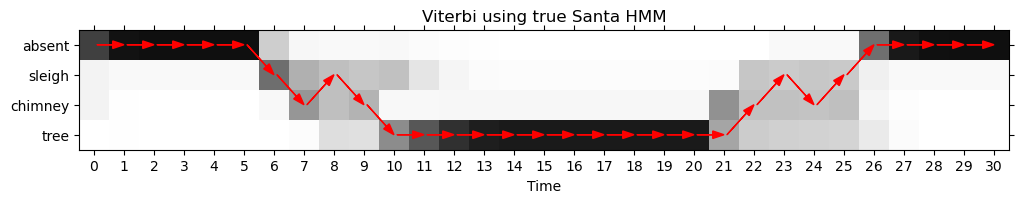

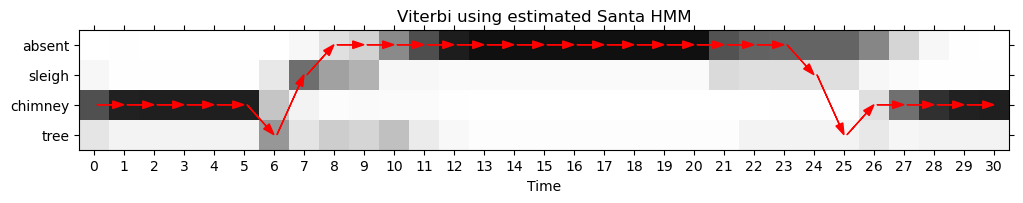

In [40]:
obs = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0])
estimated_vt, estimated_vtp  = viterbi(estimated_santa_hmm, obs)
true_vt, true_vtp  = viterbi(true_santa_hmm, obs)
plot_states(true_vtp, true_vt, 'Viterbi using true Santa HMM')
plot_states(estimated_vtp, estimated_vt, 'Viterbi using estimated Santa HMM')

<div class="alert alert-warning"> Identify the remaining inconsistency in our estimated Santa HMM and resolve it by storing the correct value in the variable <i>perm</i>. (1 point) </div>

Oops, something doesn’t seem quite right. The Baum-Welch algorithm looks solid: the log-likelihood with respect to the training observations increases monotonically in every EM iteration, and the training and test log-likelihoods compared to those of the true Santa HMM seem very reasonable. 

We would expect the paths found via Viterbi decoding to differ slightly between the estimated and true Santa HMM due to some variability. But here’s the catch: the paths differ far more than expected. What might be causing this inconsistency in the path found by the estimated Santa HMM?

If your solution is correct, plotting the two paths again in the code cell below should result in similar paths.

In [60]:
perm = None

# YOUR CODE HERE
# raise NotImplementedError()

import itertools

def find_top_3_permutations(hmm_true: HMM, hmm_est: HMM):
    B_true = hmm_true.B    
    B_est  = hmm_est.B 
    N = hmm_true.num_states
    
    results = []
    
    # Try every possible mapping of learned-state columns -> true-state columns
    for perm in itertools.permutations(range(N)):
        # Compute total squared difference over all columns
        #   B_true[:, i] vs B_est[:, perm[i]]
        ssd = 0.0
        for i in range(N):
            ssd += np.sum((B_true[:, i] - B_est[:, perm[i]])**2)
        
        results.append((ssd, perm))
    
    # Sort by the error score ascending
    results.sort(key=lambda x: x[0])
    
    # Return the top 3 permutations
    return results[:3]

top_3 = find_top_3_permutations(true_santa_hmm, estimated_santa_hmm)
for rank, (score, permutation) in enumerate(top_3, start=1):
    print(f"Rank {rank}: perm={permutation}, SSD={score}")


perm = [2, 0, 1, 3] # manually added

Rank 1: perm=(2, 0, 1, 3), SSD=0.05326278462402273
Rank 2: perm=(2, 3, 1, 0), SSD=0.057744174498130116
Rank 3: perm=(2, 1, 0, 3), SSD=0.5196939233880917


In [61]:
from collections.abc import Iterable

assert perm is not None, "You must define the variable 'perm'!"
assert isinstance(perm, Iterable), "'perm' must be an iterable!"
assert len(perm) == 4, "'perm' must contain exactly 4 elements (one for each state)!"
assert all([isinstance(elem, int) for elem in perm]), "the 4 elements of 'perm' must be integers"


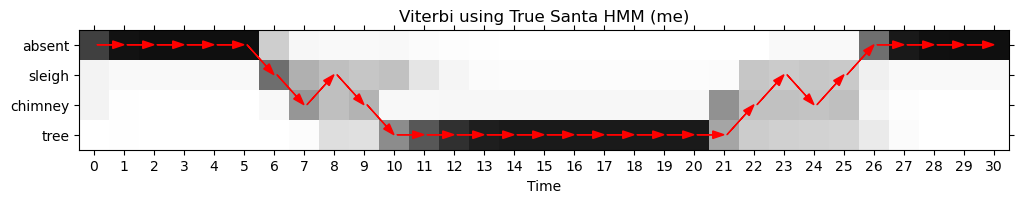

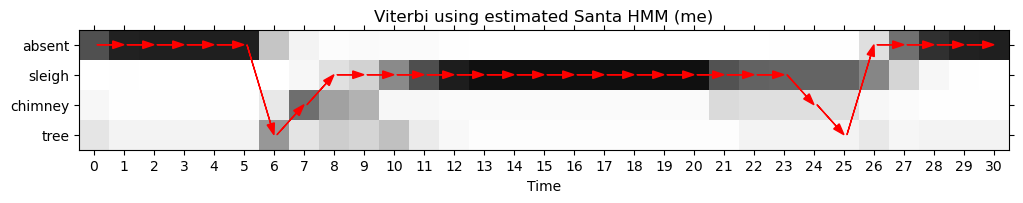

In [62]:
pi_aligned = estimated_santa_hmm.pi[perm]
A_aligned = estimated_santa_hmm.A[perm][:, perm]
B_aligned = estimated_santa_hmm.B[:, perm]
aligned_santa_hmm = HMM(pi_aligned, A_aligned, B_aligned)

estimated_vt, estimated_vtp  = viterbi(aligned_santa_hmm, obs)
true_vt, true_vtp  = viterbi(true_santa_hmm, obs)
plot_states(true_vtp, true_vt, 'Viterbi using True Santa HMM (me)')
plot_states(estimated_vtp, estimated_vt, 'Viterbi using estimated Santa HMM (me)')